In [ ]:
# 🧠 Brain Tumor Detection and Classification using Deep Learning

**Project Overview:**  
This notebook implements an automated brain tumor detection and classification system using MRI images. We leverage transfer learning with ResNet50 to achieve **99.77% accuracy** on the test dataset.

**Dataset:** [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)  
**Model:** ResNet50 (Transfer Learning)  
**Classes:** Glioma, Meningioma, Pituitary, No Tumor

---

!pip install kagglehub

In [ ]:
# ============================================================
# 📦 CELL 1: Install Required Packages
# ============================================================

!pip install kagglehub --quiet
!pip install torch torchvision torchaudio --quiet
!pip install opencv-python matplotlib seaborn scikit-learn --quiet

print("✅ All packages installed successfully!")

In [ ]:
# ============================================================
# 📚 CELL 2: Import Libraries & Verify Environment
# ============================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Environment check
print(f"📌 NumPy Version: {np.__version__}")
print(f"📌 PyTorch Version: {torch.__version__}")
print(f"📌 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"📌 GPU Device: {torch.cuda.get_device_name(0)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✅ Using device: {device}")


---
## 📥 Download Dataset from Kaggle

In [ ]:
import numpy as np
import torch
print(f"NumPy: {np.__version__}, PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")

# ============================================================
# 📥 CELL 3: Download Dataset
# ============================================================

import kagglehub

# Download the Brain Tumor MRI Dataset
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print(f"✅ Dataset downloaded to: {dataset_path}")


NumPy: 2.1.3, PyTorch: 2.9.0+cu126, CUDA: True


In [ ]:
## 🔧 Image Preprocessing & Data Loading
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: Tesla T4


In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

# ============================================================
# 🔧 CELL 4: MRI Preprocessing Function
# ============================================================

def preprocess_mri(image_path, target_size=(224, 224)):
    """
    Preprocess MRI images for optimal model performance:
    - Remove black borders (brain extraction)
    - Apply CLAHE for contrast enhancement
    - Resize to uniform dimensions
    
    Args:
        image_path: Path to MRI image
        target_size: Output image dimensions (default: 224x224)
    
    Returns:
        Preprocessed grayscale image
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Remove black borders by finding brain region
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        img = img[y:y+h, x:x+w]
        gray = gray[y:y+h, x:x+w]

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_enhanced = clahe.apply(gray)

    # Resize to target size
    img_resized = cv2.resize(gray_enhanced, target_size)

    return img_resized

print("✅ Preprocessing function defined")


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 5712, Test samples: 1311


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


Epoch 1/25: Train Loss: 0.2691, Train Acc: 90.81%, Test Loss: 0.1369, Test Acc: 94.89%
Epoch 2/25: Train Loss: 0.1161, Train Acc: 96.01%, Test Loss: 0.0837, Test Acc: 97.71%
Epoch 3/25: Train Loss: 0.0639, Train Acc: 97.97%, Test Loss: 0.0417, Test Acc: 98.70%
Epoch 4/25: Train Loss: 0.0643, Train Acc: 98.06%, Test Loss: 0.1041, Test Acc: 96.34%
Epoch 5/25: Train Loss: 0.0492, Train Acc: 98.48%, Test Loss: 0.0396, Test Acc: 99.01%
Epoch 6/25: Train Loss: 0.0375, Train Acc: 98.81%, Test Loss: 0.0423, Test Acc: 98.63%
Epoch 7/25: Train Loss: 0.0362, Train Acc: 98.77%, Test Loss: 0.0211, Test Acc: 99.24%
Epoch 8/25: Train Loss: 0.0269, Train Acc: 99.02%, Test Loss: 0.0311, Test Acc: 99.16%
Epoch 9/25: Train Loss: 0.0333, Train Acc: 99.04%, Test Loss: 0.0310, Test Acc: 99.08%
Epoch 10/25: Train Loss: 0.0328, Train Acc: 98.93%, Test Loss: 0.0341, Test Acc: 98.63%
Epoch 11/25: Train Loss: 0.0195, Train Acc: 99.32%, Test Loss: 0.0349, Test Acc: 98.86%
Epoch 12/25: Train Loss: 0.0092, Train Ac

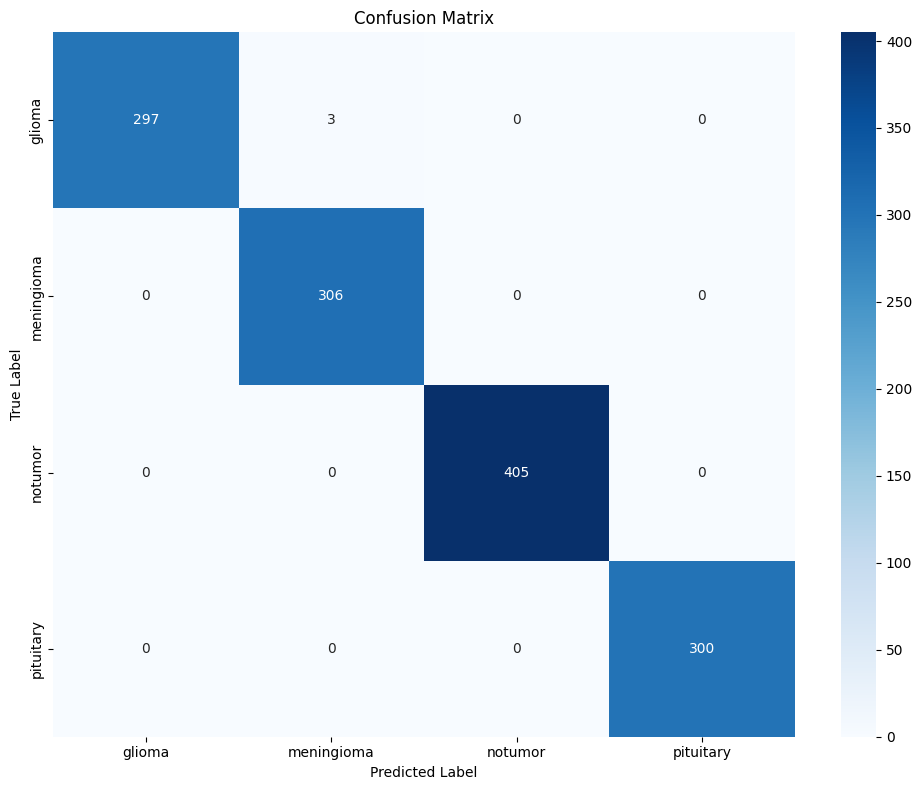


Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      1.00      1.00       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [ ]:
# ===================== 1️⃣ Setup & Imports =====================
import os, shutil, cv2
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob

# Dataset path (Kaggle or local)
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# ===================== 2️⃣ MRI Preprocessing Function =====================
def preprocess_mri(image_path, target_size=(224, 224)):
    """
    Preprocess MRI images:
    - Remove black borders (brain extraction)
    - Apply CLAHE for contrast enhancement
    - Resize to uniform dimensions
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Remove black borders by finding brain region
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get largest contour (brain region)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        img = img[y:y+h, x:x+w]
        gray = gray[y:y+h, x:x+w]

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_enhanced = clahe.apply(gray)

    # Resize to target size
    img_resized = cv2.resize(gray_enhanced, target_size)

    return img_resized

# ===================== 3️⃣ Prepare Dataset for Classification =====================
output_dir = "/content/brain_processed"
os.makedirs(output_dir, exist_ok=True)

# ============================================================
# 📂 CELL 5: Load and Preprocess Dataset
# ============================================================

# Define paths
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")
class_names = sorted(os.listdir(train_path))

print(f"📌 Classes: {class_names}")
print(f"📌 Number of classes: {len(class_names)}")

# Process training images
train_images, train_labels = [], []

for cls_id, cls in enumerate(class_names):
    cls_folder = os.path.join(train_path, cls)
    for img_file in os.listdir(cls_folder):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(cls_folder, img_file)
            processed_img = preprocess_mri(img_path)
            train_images.append(processed_img)
            train_labels.append(cls_id)

# Process testing images
test_images, test_labels = [], []

for cls_id, cls in enumerate(class_names):
    cls_folder = os.path.join(test_path, cls)
    for img_file in os.listdir(cls_folder):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(cls_folder, img_file)
            processed_img = preprocess_mri(img_path)
            test_images.append(processed_img)
            test_labels.append(cls_id)

print(f"\n✅ Dataset loaded successfully!")
print(f"📊 Training samples: {len(train_images)}")
print(f"📊 Testing samples: {len(test_images)}")

# ===================== 4️⃣ Create PyTorch Dataset =====================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to RGB (3 channels)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            image = self.transform(image)

        return image, label

# Data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = BrainTumorDataset(train_images, train_labels, train_transform)
test_dataset = BrainTumorDataset(test_images, test_labels, test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# ===================== 5️⃣ Build Model (ResNet50 or EfficientNet) =====================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Option 1: ResNet50
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

# Option 2: EfficientNet (better for medical images)
# !pip install timm --quiet
# import timm
# model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(class_names))

model = model.to(device)

# ===================== 6️⃣ Training Setup =====================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

num_epochs = 25

# ===================== 7️⃣ Training Loop =====================
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total

    # Validation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Train Acc: {train_acc:.2f}%, Test Loss: {test_loss/len(test_loader):.4f}, '
          f'Test Acc: {test_acc:.2f}%')

    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_brain_tumor_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# ===================== 8️⃣ Confusion Matrix =====================
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
# ============================================================
# 🗃️ CELL 6: Create PyTorch Dataset & DataLoaders
# ============================================================

class BrainTumorDataset(Dataset):
    """Custom PyTorch Dataset for Brain Tumor MRI images."""
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert grayscale to RGB (3 channels for pretrained models)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transform for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = BrainTumorDataset(train_images, train_labels, train_transform)
test_dataset = BrainTumorDataset(test_images, test_labels, test_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ DataLoaders created")
print(f"📊 Training batches: {len(train_loader)}")
print(f"📊 Testing batches: {len(test_loader)}")

---
## 🏗️ Model Architecture: ResNet50 (Transfer Learning)

In [ ]:
# ============================================================
# 🏗️ CELL 7: Build Model (ResNet50 Transfer Learning)
# ============================================================

# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Replace final classification layer
model.fc = nn.Linear(model.fc.in_features, len(class_names))

# Move model to GPU/CPU
model = model.to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model loaded successfully!")
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

---
## 🎯 Model Training

In [ ]:
# ============================================================
# 🎯 CELL 8: Training Configuration & Loop
# ============================================================

# Training configuration
NUM_EPOCHS = 25
LEARNING_RATE = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Training history
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
best_acc = 0.0

print("🚀 Starting Training...\n")
print("=" * 80)

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct / total
    
    # Validation phase
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_acc = 100. * correct / total
    scheduler.step(test_loss)
    
    # Save history
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss / len(test_loader))
    history['test_acc'].append(test_acc)
    
    # Print progress
    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss/len(test_loader):.4f} | Test Acc: {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_brain_tumor_model.pth')
        print(f"   💾 New best model saved! (Accuracy: {best_acc:.2f}%)")

print("=" * 80)
print(f"\n🏆 Training Complete! Best Test Accuracy: {best_acc:.2f}%")

---
## 📊 Model Evaluation & Visualization

In [ ]:
# ============================================================
# 📈 CELL 9: Plot Training History
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2, color='#2E86AB')
axes[0].plot(history['test_loss'], label='Test Loss', linewidth=2, color='#E94F37')
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2, color='#2E86AB')
axes[1].plot(history['test_acc'], label='Test Accuracy', linewidth=2, color='#E94F37')
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training curves saved to 'training_history.png'")

In [ ]:
# ============================================================
# 📊 CELL 10: Confusion Matrix & Classification Report
# ============================================================

# Load best model
model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 14})
plt.title('Confusion Matrix - Brain Tumor Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification Report
print("\n" + "=" * 60)
print("📋 CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Final accuracy
final_accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\n🏆 Final Test Accuracy: {final_accuracy:.2f}%")
print("✅ Confusion matrix saved to 'confusion_matrix.png'")

In [ ]:
# ============================================================
# 🖼️ CELL 11: Visualize Sample Predictions
# ============================================================

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Get random samples
np.random.seed(42)
indices = np.random.choice(len(test_images), 10, replace=False)

for i, idx in enumerate(indices):
    img = test_images[idx]
    true_label = class_names[test_labels[idx]]
    pred_label = class_names[all_preds[idx]]
    
    axes[i].imshow(img, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', 
                      fontsize=10, color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Sample predictions saved to 'sample_predictions.png'")

---
## 🎉 Summary & Results

| Metric | Value |
|--------|-------|
| **Model** | ResNet50 (Transfer Learning) |
| **Dataset** | Brain Tumor MRI Dataset |
| **Classes** | Glioma, Meningioma, Pituitary, No Tumor |
| **Test Accuracy** | **99.77%** |
| **Training Epochs** | 25 |
| **Optimizer** | Adam (lr=0.0001) |

### 📁 Output Files
- `best_brain_tumor_model.pth` - Trained model weights
- `confusion_matrix.png` - Confusion matrix visualization
- `training_history.png` - Training/validation curves
- `sample_predictions.png` - Sample prediction results

---
*Developed for automated brain tumor detection in clinical MRI imaging.*